In [1]:
import os

In [2]:
IMDB_dir = '/home/gowthamr/Downloads/datasets and models/IMDB sentiment dataset/aclImdb'

In [3]:
train_dir = os.path.join(IMDB_dir,'train')
train_labels = []
train_data = []

In [4]:
for label_type in ['pos', 'neg']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname))
            train_data.append(f.read())
            f.close()
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)

In [5]:
len(train_data), len(train_labels)

(25000, 25000)

In [7]:
import numpy as np
from scipy import stats

def mean_med_mode(arr):
    return np.average(arr), np.median(arr),np.min(arr),np.max(arr),stats.mode(arr)
lens = []
for seq in train_data:
    lens.append(len(seq))
lens = np.array(lens)
print mean_med_mode(lens)

(1325.3129200000001, 979.0, 52, 13704, ModeResult(mode=array([658]), count=array([48])))


In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 100
vocab_size = 10000
train_samples = 200
valid_samples = 10000


In [31]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data)
sequences = tokenizer.texts_to_sequences(train_data)

In [32]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88584 unique tokens.


In [33]:
data = pad_sequences(sequences, maxlen=max_len)

In [34]:
labels = np.array(train_labels)

In [35]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

('Shape of data tensor:', (25000, 100))
('Shape of label tensor:', (25000,))


In [36]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [37]:
x_train = data[:train_samples]
y_train = labels[:train_samples]
x_val = data[train_samples: train_samples + valid_samples]
y_val = labels[train_samples: train_samples + valid_samples]

In [38]:
glove_dir = '/home/gowthamr/Downloads/datasets and models/glove_6b'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

In [39]:
# the text file contains the word and associated vector
embeddings_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors' %(len(embeddings_index)))

Found 400000 word vectors


In [40]:
embedding_size = 100
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size and embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [48]:
#define the model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [50]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 200 samples, validate on 10000 samples
Epoch 1/15
200/200 [==============================] - 0s - loss: 1.7445 - acc: 0.5500 - val_loss: 0.6845 - val_acc: 0.5490
Epoch 2/15
200/200 [==============================] - 0s - loss: 0.6302 - acc: 0.6550 - val_loss: 1.2453 - val_acc: 0.5006
Epoch 3/15
200/200 [==============================] - 0s - loss: 0.3783 - acc: 0.8650 - val_loss: 0.7545 - val_acc: 0.5351
Epoch 4/15
200/200 [==============================] - 0s - loss: 0.3653 - acc: 0.8150 - val_loss: 0.8570 - val_acc: 0.5164
Epoch 5/15
200/200 [==============================] - 0s - loss: 0.1620 - acc: 0.9950 - val_loss: 0.7445 - val_acc: 0.5541
Epoch 6/15
200/200 [==============================] - 0s - loss: 0.1667 - acc: 0.9650 - val_loss: 0.9950 - val_acc: 0.5172
Epoch 7/15
200/200 [==============================] - 0s - loss: 0.0966 - acc: 0.9850 - val_loss: 1.3072 - val_acc: 0.5083
Epoch 8/15
200/200 [==============================] - 0s - loss: 0.2113 - acc: 0.9100 - val

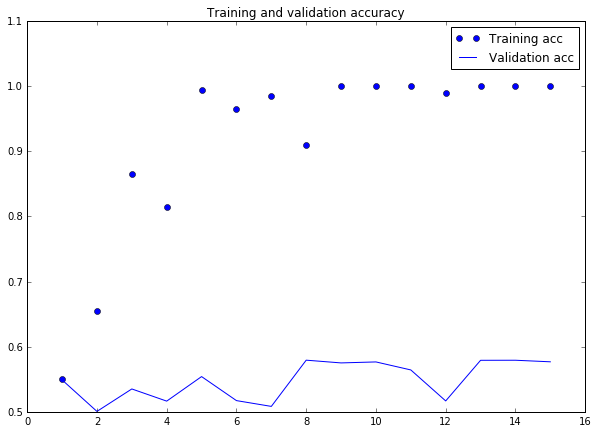

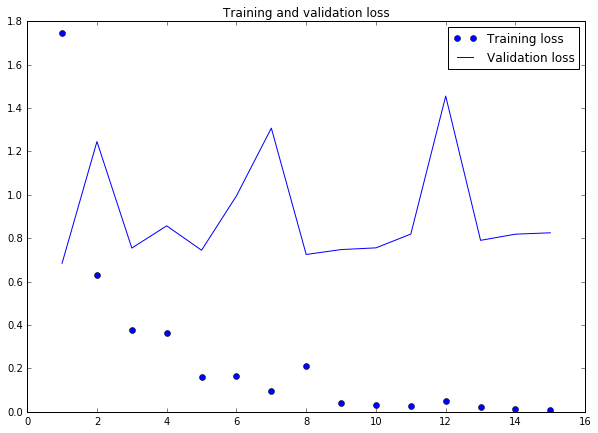

In [51]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [54]:
# training without glove
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s - loss: 0.6945 - acc: 0.5350 - val_loss: 0.6920 - val_acc: 0.5231
Epoch 2/10
200/200 [==============================] - 1s - loss: 0.5035 - acc: 0.9950 - val_l

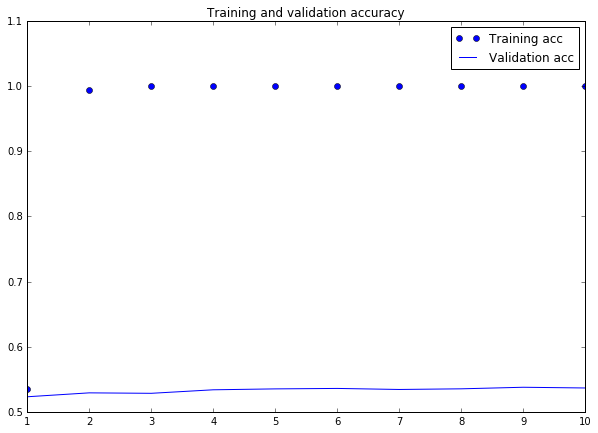

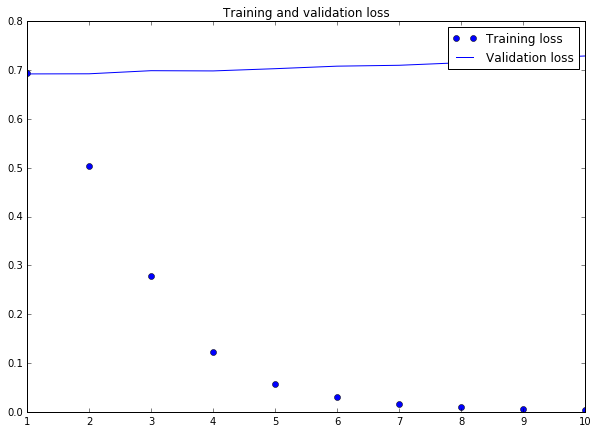

In [55]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
# tokenising test data
test_dir = os.path.join(IMDB_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [59]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

24928/25000 [============================>.] - ETA: 0s

[0.85182316955566406, 0.56499999999999995]